In [1]:
import os
import re
from pathlib import Path

import scanpy as sc
import pandas as pd
import numpy as np
import tifffile
import torch
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
from torchvision import transforms
from skimage.morphology import disk
from skimage.color import label2rgb

from einops import rearrange

In [2]:
spaceranger_outs = '/storage1/fs1/dinglab/Active/Projects/estorrs/deep-spatial-genomics/data/brca/HT397B1-S1H2A4/spaceranger_outs/outs'
full_res_he_fp = '/storage1/fs1/dinglab/Active/Projects/estorrs/deep-spatial-genomics/data/brca/HT397B1-S1H2A4/full_res_he.tif'
out_dir = '/storage1/fs1/dinglab/Active/Projects/estorrs/deep-spatial-genomics/data/brca/HT397B1-S1H2A4'
Path(out_dir).mkdir(parents=True, exist_ok=True)

In [4]:
spaceranger_outs = '/storage1/fs1/dinglab/Active/Projects/estorrs/deep-spatial-genomics/data/brca/HT397B1-S1H3A1/spaceranger_outs'
full_res_he_fp = '/storage1/fs1/dinglab/Active/Projects/estorrs/deep-spatial-genomics/data/brca/HT397B1-S1H3A1/full_res_he.tif'
out_dir = '/storage1/fs1/dinglab/Active/Projects/estorrs/deep-spatial-genomics/data/brca/HT397B1-S1H3A1'
Path(out_dir).mkdir(parents=True, exist_ok=True)

In [2]:
# out_dir = '/storage1/fs1/dinglab/Active/Projects/estorrs/deep-spatial-genomics/data/pdac/HT264P1-S1H2U1'
# out_dir = '/storage1/fs1/dinglab/Active/Projects/estorrs/deep-spatial-genomics/data/pdac/HT270P1-S1H1U1/'
out_dir = '/storage1/fs1/dinglab/Active/Projects/estorrs/deep-spatial-genomics/data/pdac/HT434P1-S1H3U1/'
spaceranger_outs = os.path.join(out_dir, 'spaceranger_outs')
full_res_he_fp = os.path.join(out_dir, 'full_res_he.tif')
Path(out_dir).mkdir(parents=True, exist_ok=True)

#### read in data and light preprocessing on spaceranger output

In [3]:
a = sc.read_visium(spaceranger_outs)
a.var_names_make_unique()
a

/miniconda/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 3018 × 17943
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [4]:
# save raw counts for future use
a.layers['counts'] = a.X.copy()

# stadard ST expression normalization
sc.pp.normalize_total(a, inplace=True)
sc.pp.log1p(a)

# identifying most variable genes, not actually filtering on them
sc.pp.highly_variable_genes(a, flavor="seurat", n_top_genes=2000)

# getting some initial umap and clustering results
# NOTE: may not be the most reliable given we didn't filter for only most variable genes
sc.pp.pca(a)
sc.pp.neighbors(a)
sc.tl.umap(a)
sc.tl.leiden(a, key_added="clusters")

In [5]:
# bug in newer spaceranger that reads in coords as strings for some reason
a.obsm['spatial'] = a.obsm['spatial'].astype(np.int32)

###### Add annotation from alla, skip this section if manual annotations are not present

In [5]:
df = pd.read_csv(
    '/storage1/fs1/dinglab/Active/Projects/estorrs/deep-spatial-genomics/data/brca/HT397B1-S1H2A4/alla_annotations.csv',
    index_col=0)
df

Immune
Barcode                  
AAACAAGTATCTCCCA-1    NaN
AAACACCAATAACTGC-1  Tumor
AAACAGAGCGACTCCT-1    NaN
AAACAGCTTTCAGAAG-1    NaN
AAACAGGGTCTATATT-1    NaN
...                   ...
TTGTTCTAGATACGCT-1    NaN
TTGTTGGCAATGACTG-1    NaN
TTGTTTCACATCCAGG-1    NaN
TTGTTTCATTAGTCTA-1    NaN
TTGTTTGTATTACACG-1    NaN

[3561 rows x 1 columns]

In [6]:
set(df['Immune'])

{'Fibroblasts', 'Immune', 'Tumor', nan}

In [7]:
a.obs['alla_label'] = [df.loc[b, 'Immune'] for b in a.obs.index]
a.obs

in_tissue  array_row  array_col clusters alla_label
AAACAAGTATCTCCCA-1          1         50        102        0        NaN
AAACACCAATAACTGC-1          1         59         19        9      Tumor
AAACAGAGCGACTCCT-1          1         14         94        3        NaN
AAACAGCTTTCAGAAG-1          1         43          9       11        NaN
AAACAGGGTCTATATT-1          1         47         13        1        NaN
...                       ...        ...        ...      ...        ...
TTGTTCTAGATACGCT-1          1         21          3       11        NaN
TTGTTGGCAATGACTG-1          1         76         30        6        NaN
TTGTTTCACATCCAGG-1          1         58         42        2        NaN
TTGTTTCATTAGTCTA-1          1         60         30        6        NaN
TTGTTTGTATTACACG-1          1         73         41        5        NaN

[3561 rows x 5 columns]

###### Read in full resolution H&E image

In [6]:
img = tifffile.imread(full_res_he_fp)
img.shape

(19888, 19620, 3)

In [7]:
a.uns['full_res_he'] = img

some visuals

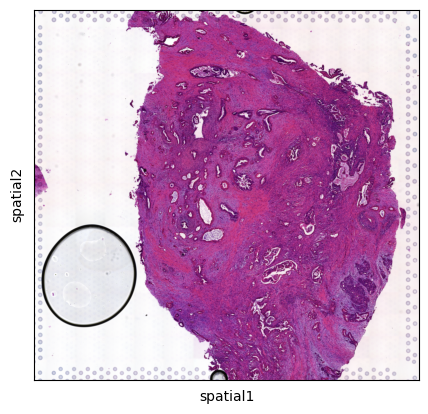

In [8]:
sc.pl.spatial(a)

In [9]:
# sc.pl.spatial(a, color='alla_label')

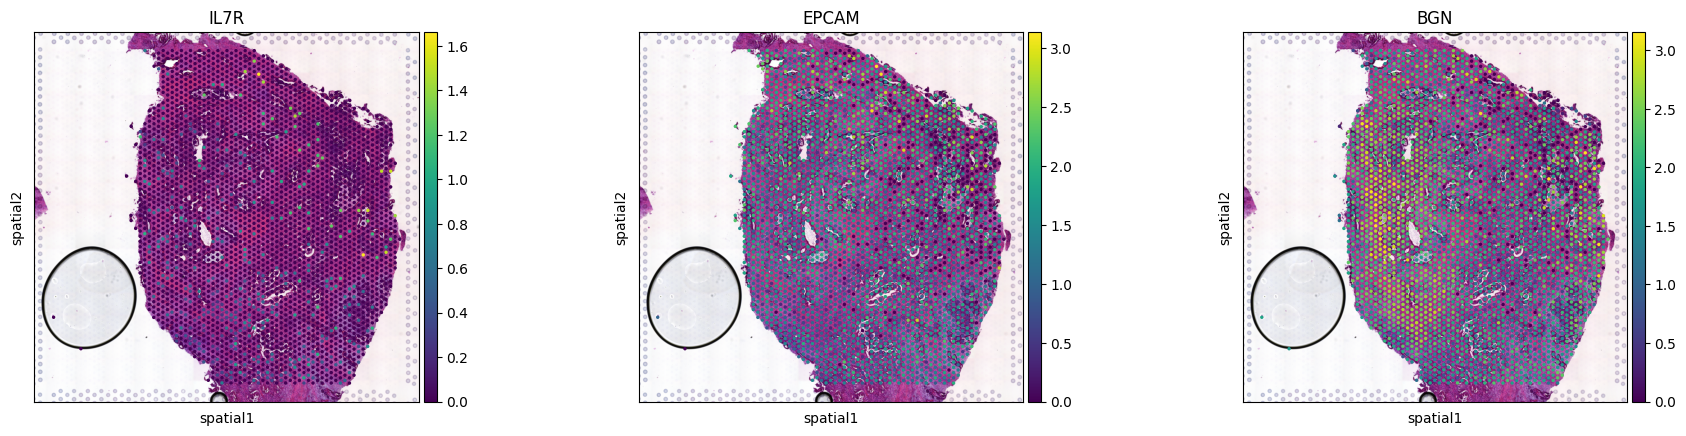

In [10]:
sc.pl.spatial(a, color=['IL7R', 'EPCAM', 'BGN'])

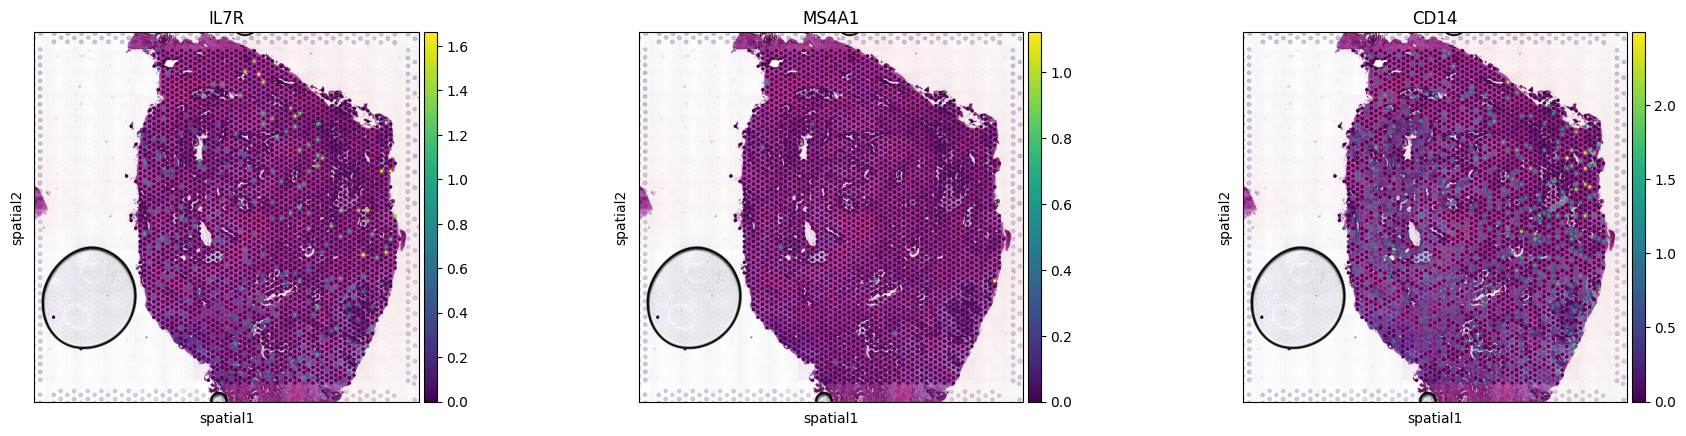

In [11]:
sc.pl.spatial(a, color=['IL7R', 'MS4A1', 'CD14'])

#### H&E preprocessing

goal is to make several different resolutions of H&E with matching labeled spot masks, spot coordinates, and spot metadata

In [12]:
spot_diameter = next(iter(a.uns['spatial'].values()))['scalefactors']['spot_diameter_fullres']
spot_diameter, spot_radius = int(spot_diameter), int(spot_diameter / 2)
spot_diameter, spot_radius

(161, 80)

cut off the fiducial spots around the edges. might be useful to have H&E images without fiducial spots in them so the model cant tell that the H&E is from spatial transcriptomics

In [13]:
c_min, r_min = np.min(a.obsm['spatial'], axis=0) - spot_radius
c_max, r_max = np.max(a.obsm['spatial'], axis=0) + spot_radius

trimmed = img[r_min:r_max, c_min:c_max]

In [14]:
a.uns['trimmed'] = trimmed
a.obsm['spatial_trimmed'] = a.obsm['spatial'] + np.asarray([-c_min, -r_min])

rescaling H&E to different resolutions.

currently using: 1X, 2X, 4X, 8X, 16X (and a 512x512 of the entire slide with reflective padding)

In [15]:
def rescale_img(img, scale=.5, shape=None):
    if shape is None:
        h, w = int(img.shape[0] * scale), int(img.shape[1] * scale)
    else:
        h, w = shape
    scaled = TF.resize(rearrange(torch.Tensor(img), 'h w c -> c h w'), size=(h, w))
    return rearrange(scaled, 'c h w -> h w c').numpy().astype(np.uint8)

def rescale_with_pad(img, scale=.5, shape=None):
    if shape is None:
        h, w = int(img.shape[0] * scale), int(img.shape[1] * scale)
    else:
        h, w = shape
    r, c = img.shape[0], img.shape[1]
    
    right_pad = r-c if r>c else 0
    bottom_pad = c-r if c>r else 0
    padded = TF.pad(rearrange(torch.Tensor(img), 'h w c -> c h w'),
                    padding=[0, 0, right_pad, bottom_pad], padding_mode='reflect')
    
    scaled = TF.resize(padded, size=(h, w))
    return rearrange(scaled, 'c h w -> h w c').numpy().astype(np.uint8)

In [16]:
scales = [1, 2, 4, 8, 16]
rescaled_dict = {}
res_dict = {}
for scale in scales:
    scaled = rescale_img(img, scale=1./scale)
    rescaled_dict[f'{scale}X_notrim'] = scaled
    res_dict[f'{scale}X_notrim'] = {
        'spot_diameter': int(spot_diameter / scale),
        'spot_radius': int(spot_radius / scale)
    }
    a.obsm[f'spatial_{scale}X_notrim'] = a.obsm['spatial'] / scale
    
    scaled = rescale_img(trimmed, scale=1./scale)
    rescaled_dict[f'{scale}X_trimmed'] = scaled
    res_dict[f'{scale}X_trimmed'] = {
        'spot_diameter': int(spot_diameter / scale),
        'spot_radius': int(spot_radius / scale)
    }
    a.obsm[f'spatial_{scale}X_trimmed'] = a.obsm['spatial_trimmed'] / scale
    
rescaled_dict['512x512_notrim'] = rescale_with_pad(img, shape=(512, 512))
res_dict['512x512_notrim'] = {
    'spot_diameter': int(spot_diameter * (512. / max(img.shape[0], img.shape[1]))),
    'spot_radius': int(spot_radius * (512. / max(img.shape[0], img.shape[1]))),
}

rescaled_dict['512x512_trimmed'] = rescale_with_pad(trimmed, shape=(512, 512))
res_dict['512x512_trimmed'] = {
    'spot_diameter': int(spot_diameter * (512. / max(trimmed.shape[0], trimmed.shape[1]))),
    'spot_radius': int(spot_radius * (512. / max(trimmed.shape[0], trimmed.shape[1]))),
}

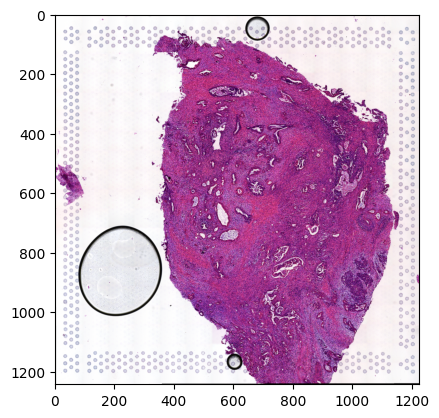

In [17]:
plt.imshow(rescaled_dict['16X_notrim'])

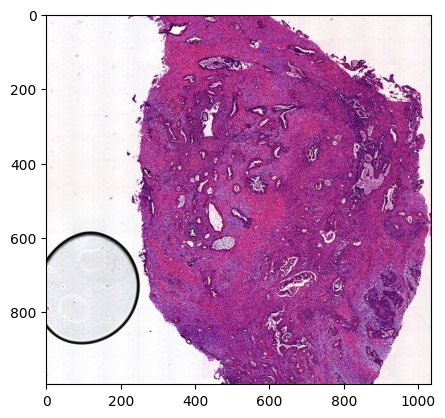

In [18]:
plt.imshow(rescaled_dict['16X_trimmed'])

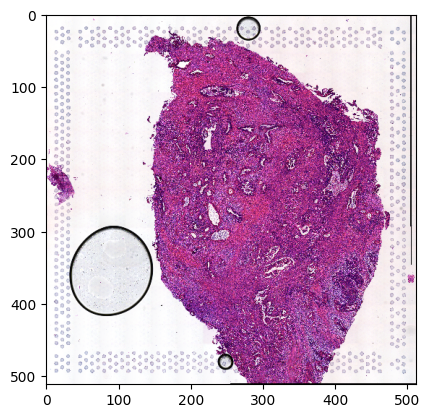

In [19]:
plt.imshow(rescaled_dict['512x512_notrim'])

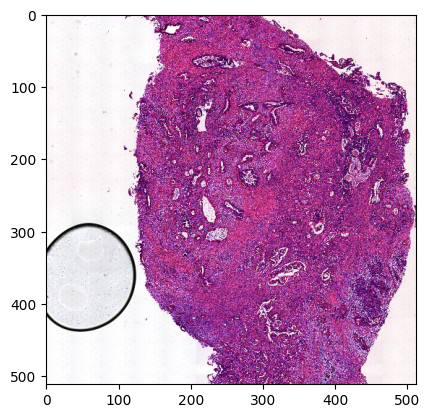

In [20]:
plt.imshow(rescaled_dict['512x512_trimmed']) # note the reflection padding

In [21]:
res_dict

{'1X_notrim': {'spot_diameter': 161, 'spot_radius': 80},
 '1X_trimmed': {'spot_diameter': 161, 'spot_radius': 80},
 '2X_notrim': {'spot_diameter': 80, 'spot_radius': 40},
 '2X_trimmed': {'spot_diameter': 80, 'spot_radius': 40},
 '4X_notrim': {'spot_diameter': 40, 'spot_radius': 20},
 '4X_trimmed': {'spot_diameter': 40, 'spot_radius': 20},
 '8X_notrim': {'spot_diameter': 20, 'spot_radius': 10},
 '8X_trimmed': {'spot_diameter': 20, 'spot_radius': 10},
 '16X_notrim': {'spot_diameter': 10, 'spot_radius': 5},
 '16X_trimmed': {'spot_diameter': 10, 'spot_radius': 5},
 '512x512_notrim': {'spot_diameter': 4, 'spot_radius': 2},
 '512x512_trimmed': {'spot_diameter': 4, 'spot_radius': 2}}

In [22]:
a.obsm.keys()

KeysView(AxisArrays with keys: spatial, X_pca, X_umap, spatial_trimmed, spatial_1X_notrim, spatial_1X_trimmed, spatial_2X_notrim, spatial_2X_trimmed, spatial_4X_notrim, spatial_4X_trimmed, spatial_8X_notrim, spatial_8X_trimmed, spatial_16X_notrim, spatial_16X_trimmed)

creating labeled masks for each H&E resolution

In [23]:
# create masks for each image
labeled_mask_dict = {}
for k, v in rescaled_dict.items():
    sr = res_dict[k]['spot_radius']
    labeled_img = np.zeros((v.shape[0], v.shape[1]), dtype=np.uint32)
    footprint = disk(radius=sr)[:-1, :-1]
    
    if re.findall(r'^[0-9]+X_', k): # exclude the 512x512
        print(k)
        for i, (c, r) in enumerate(a.obsm[f'spatial_{k}']):
            r, c = int(r), int(c)
            rect = np.zeros((sr * 2, sr * 2))
            rect[footprint>0] = i + 1
            labeled_img[r-sr:r+sr, c-sr:c+sr] = rect
        labeled_mask_dict[k] = labeled_img

1X_notrim
1X_trimmed
2X_notrim
2X_trimmed
4X_notrim
4X_trimmed
8X_notrim
8X_trimmed
16X_notrim
16X_trimmed


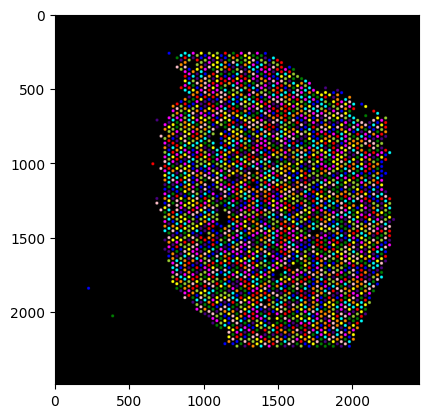

In [24]:
rgb = label2rgb(labeled_mask_dict['8X_notrim'])
plt.imshow(rgb)

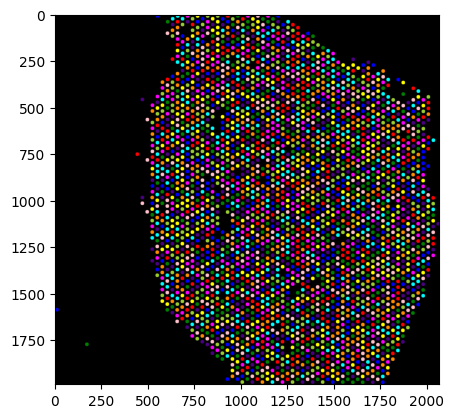

In [25]:
rgb = label2rgb(labeled_mask_dict['8X_trimmed'])
plt.imshow(rgb)

save results in anndata object

In [26]:
a.uns['rescaled_he'] = rescaled_dict
a.uns['rescaled_spot_metadata'] = res_dict
a.uns['rescaled_spot_masks'] = labeled_mask_dict

In [27]:
# spot index for each spot in labeled mask images
a.obs['spot_index'] = np.arange(a.shape[0]) + 1

In [28]:
a.write_h5ad(os.path.join(out_dir, 'adata.h5ad'))

#### sanity check to make sure H&E lines up with where spots are supposed to be

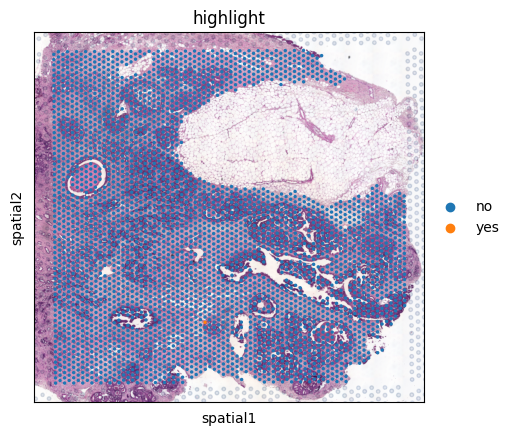

In [31]:
idx = 150
spot_id = a.obs.index[idx]
a.obs['highlight'] = ['yes' if sid==spot_id else 'no' for sid in a.obs.index]
sc.pl.spatial(a, color='highlight')

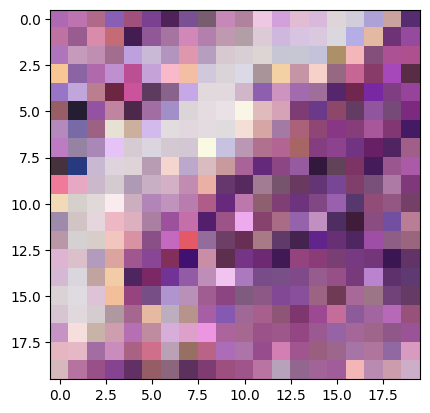

In [32]:
c, r = a[spot_id].obsm['spatial_8X_trimmed'].flatten()
c, r = int(c), int(r)
sr = a.uns['rescaled_spot_metadata']['8X_trimmed']['spot_radius']
r1, r2 = r - sr, r + sr
c1, c2 = c - sr, c + sr
plt.imshow(a.uns['rescaled_he']['8X_trimmed'][r1:r2, c1:c2])

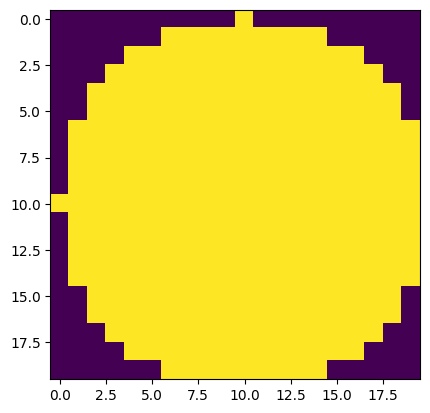

In [33]:
plt.imshow(a.uns['rescaled_spot_masks']['8X_trimmed'][r1:r2, c1:c2])

In [34]:
a.uns['rescaled_spot_masks']['8X_trimmed'][r, c] == idx + 1

True

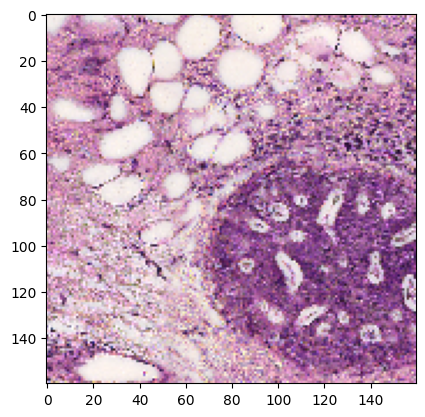

In [35]:
sr = a.uns['rescaled_spot_metadata']['8X_trimmed']['spot_radius'] * 8
r1, r2 = r - sr, r + sr
c1, c2 = c - sr, c + sr
plt.imshow(a.uns['rescaled_he']['8X_trimmed'][r1:r2, c1:c2])

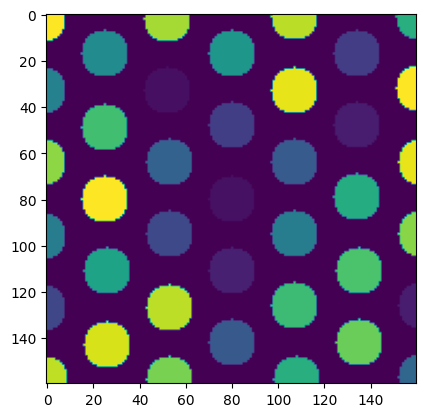

In [36]:
plt.imshow(a.uns['rescaled_spot_masks']['8X_trimmed'][r1:r2, c1:c2])

In [37]:
a.uns['rescaled_spot_masks']['8X_trimmed'][r, c] == idx + 1

True

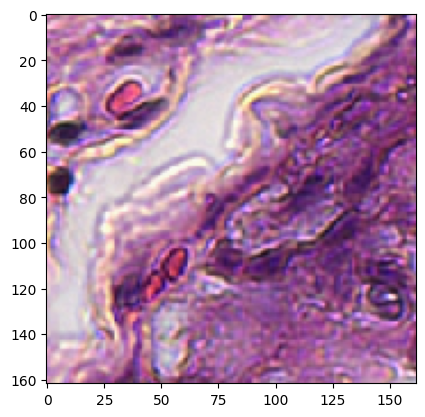

In [38]:
c, r = a[spot_id].obsm['spatial_1X_notrim'].flatten()
c, r = int(c), int(r)
sr = a.uns['rescaled_spot_metadata']['1X_notrim']['spot_radius']
r1, r2 = r - sr, r + sr
c1, c2 = c - sr, c + sr
plt.imshow(a.uns['rescaled_he']['1X_notrim'][r1:r2, c1:c2])

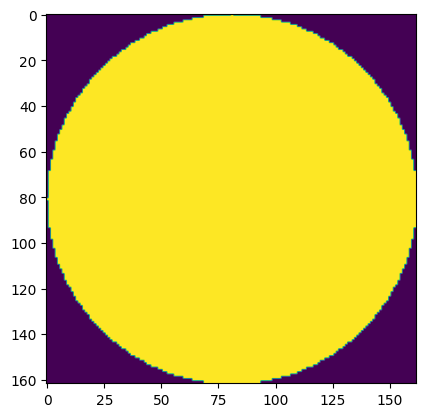

In [39]:
plt.imshow(a.uns['rescaled_spot_masks']['1X_notrim'][r1:r2, c1:c2])

In [40]:
a.uns['rescaled_spot_masks']['1X_notrim'][r, c] == idx + 1

True

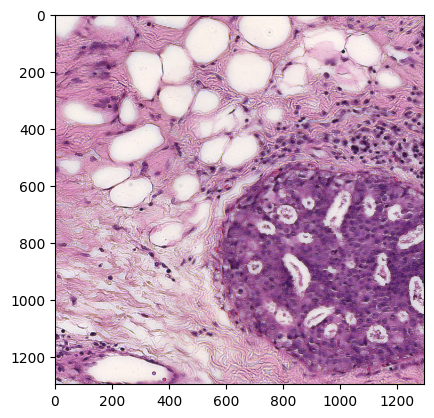

In [41]:
sr = a.uns['rescaled_spot_metadata']['1X_notrim']['spot_radius'] * 8
r1, r2 = r - sr, r + sr
c1, c2 = c - sr, c + sr
plt.imshow(a.uns['rescaled_he']['1X_notrim'][r1:r2, c1:c2])

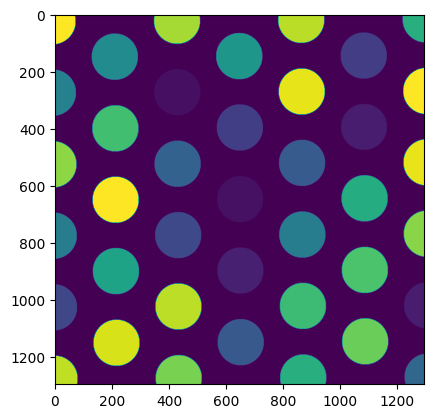

In [42]:
plt.imshow(a.uns['rescaled_spot_masks']['1X_notrim'][r1:r2, c1:c2])

In [43]:
a.uns['rescaled_spot_masks']['1X_notrim'][r, c] == idx + 1

True

In [44]:
a

AnnData object with n_obs × n_vars = 3561 × 17943
    obs: 'in_tissue', 'array_row', 'array_col', 'clusters', 'alla_label', 'spot_index', 'highlight'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'spatial', 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'full_res_he', 'alla_label_colors', 'trimmed', 'rescaled_he', 'rescaled_spot_metadata', 'rescaled_spot_masks', 'highlight_colors'
    obsm: 'spatial', 'X_pca', 'X_umap', 'spatial_trimmed', 'spatial_1X_notrim', 'spatial_1X_trimmed', 'spatial_2X_notrim', 'spatial_2X_trimmed', 'spatial_4X_notrim', 'spatial_4X_trimmed', 'spatial_8X_notrim', 'spatial_8X_trimmed', 'spatial_16X_notrim', 'spatial_16X_trimmed'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

## sandbox, ignore this

In [3]:
img = tifffile.imread('/storage1/fs1/dinglab/Active/Projects/estorrs/deep-spatial-genomics/data/brca/HT397B1-S1H2A4/full_res_he.tif')
img.shape

(19918, 19620, 3)

In [8]:
np.mean(img / 255., axis=(0,1))

array([0.77127196, 0.65175612, 0.75270245])

In [9]:
np.std(img / 255., axis=(0,1))

array([0.22921488, 0.28849901, 0.22453223])

###### start of extracting tiles for each spot, but deciding against it for now in favor of masking approach

In [161]:
from sklearn.neighbors import NearestNeighbors
import scipy
def cell_to_neighbors(adata, n=6, radius=50):
    X = adata.obsm['spatial']
    nbrs = NearestNeighbors(algorithm='ball_tree').fit(X)
    
    g = nbrs.radius_neighbors_graph(X, radius=radius)
#     g = nbrs.neighbors_graph(X, n_neighbors=6)
    rows, cols, _ = scipy.sparse.find(g)
    
    cell_to_neighbhors = {}
    for r, c in zip(rows, cols):
        cid = adata.obs.index[r]
        if cid not in cell_to_neighbhors:
            cell_to_neighbhors[cid] = []
        else:
            cell_to_neighbhors[cid].append(adata.obs.index[c])
            
    return cell_to_neighbhors

In [147]:
a.uns['spot_to_1hop_neighbors'] = cell_to_neighbors(a, n=6, radius=300)
a.uns['spot_to_2hop_neighbors'] = cell_to_neighbors(a, n=12, radius=600)

In [167]:
def plot_spot_neighbors(a, spot, key='spot_to_1hop_neighbors'):
    a.obs['highlight'] = ['yes' if x in a.uns[key][spot] or x==spot else 'no'
                         for x in a.obs.index]
    sc.pl.spatial(a, color='highlight')

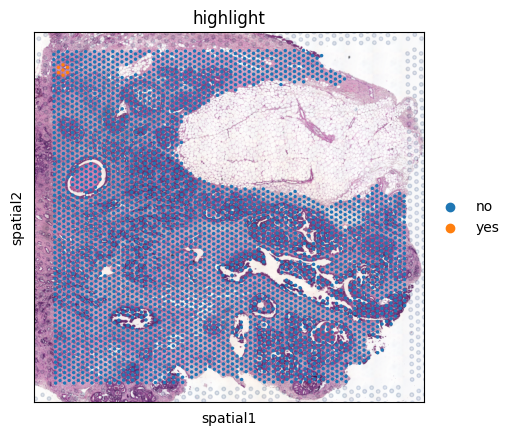

In [164]:
idx = 110
spot = a.obs.index[idx]
plot_spot_neighbors(a, spot)

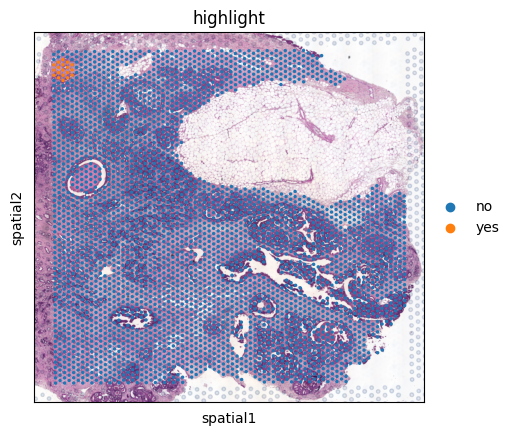

In [168]:
idx = 110
spot = a.obs.index[idx]
plot_spot_neighbors(a, spot, key='spot_to_2hop_neighbors')

In [151]:
a.uns['spot_to_1hop_neighbors'][spot]

['ATACCCTCCCGGCCAA-1',
 'CGCCAGTAGTACCTTG-1',
 'CTCCCTTGTATCAAGG-1',
 'GCTACTCGGACGCAGA-1',
 'TCTGTTTAGATTGTTC-1',
 'TGAACCTGAATGTGAG-1']

In [157]:
cs = a[a.uns['spot_to_1hop_neighbors'][spot]].obsm['spatial']
region_width, region_height = np.max(cs, axis=0) - np.min(cs, axis=0)
region_width, region_height

(438, 501)

In [160]:
for spot in a.obs.index[:20]:
    cs = a[a.uns['spot_to_1hop_neighbors'][spot]].obsm['spatial']
    region_width, region_height = np.max(cs, axis=0) - np.min(cs, axis=0)
    print(spot, cs.shape, region_width, region_height)

AAACAAGTATCTCCCA-1 (6, 2) 437 501
AAACACCAATAACTGC-1 (6, 2) 437 501
AAACAGAGCGACTCCT-1 (4, 2) 437 377
AAACAGCTTTCAGAAG-1 (6, 2) 437 501
AAACAGGGTCTATATT-1 (6, 2) 437 501
AAACAGTGTTCCTGGG-1 (6, 2) 437 501
AAACATGGTGAGAGGA-1 (3, 2) 435 126
AAACATTTCCCGGATT-1 (6, 2) 437 501
AAACCCGAACGAAATC-1 (6, 2) 437 501
AAACCGGAAATGTTAA-1 (6, 2) 437 501
AAACCGTTCGTCCAGG-1 (6, 2) 437 501
AAACGAAGAACATACC-1 (6, 2) 437 501
AAACGAGACGGTTGAT-1 (5, 2) 437 376
AAACGCTGGGCACGAC-1 (5, 2) 437 377
AAACGGGCGTACGGGT-1 (6, 2) 437 501
AAACGGTTGCGAACTG-1 (6, 2) 437 501
AAACGTGTTCGCCCTA-1 (6, 2) 437 501
AAACTCGGTTCGCAAT-1 (6, 2) 437 501
AAACTCGTGATATAAG-1 (6, 2) 437 501
AAACTGCTGGCTCCAA-1 (6, 2) 437 501


In [171]:
for spot in a.obs.index[:20]:
    cs = a[a.uns['spot_to_2hop_neighbors'][spot]].obsm['spatial']
    region_width, region_height = np.max(cs, axis=0) - np.min(cs, axis=0)
    print(spot, cs.shape, region_width, region_height)

AAACAAGTATCTCCCA-1 (18, 2) 874 1002
AAACACCAATAACTGC-1 (17, 2) 874 1001
AAACAGAGCGACTCCT-1 (10, 2) 875 754
AAACAGCTTTCAGAAG-1 (17, 2) 873 1002
AAACAGGGTCTATATT-1 (18, 2) 874 1001
AAACAGTGTTCCTGGG-1 (17, 2) 874 1002
AAACATGGTGAGAGGA-1 (10, 2) 873 503
AAACATTTCCCGGATT-1 (18, 2) 874 1001
AAACCCGAACGAAATC-1 (18, 2) 874 1002
AAACCGGAAATGTTAA-1 (17, 2) 874 877
AAACCGTTCGTCCAGG-1 (18, 2) 874 1001
AAACGAAGAACATACC-1 (18, 2) 874 1001
AAACGAGACGGTTGAT-1 (15, 2) 873 1002
AAACGCTGGGCACGAC-1 (12, 2) 872 628
AAACGGGCGTACGGGT-1 (18, 2) 874 1002
AAACGGTTGCGAACTG-1 (18, 2) 874 1002
AAACGTGTTCGCCCTA-1 (18, 2) 874 1001
AAACTCGGTTCGCAAT-1 (18, 2) 874 1001
AAACTCGTGATATAAG-1 (18, 2) 874 1001
AAACTGCTGGCTCCAA-1 (18, 2) 874 1002


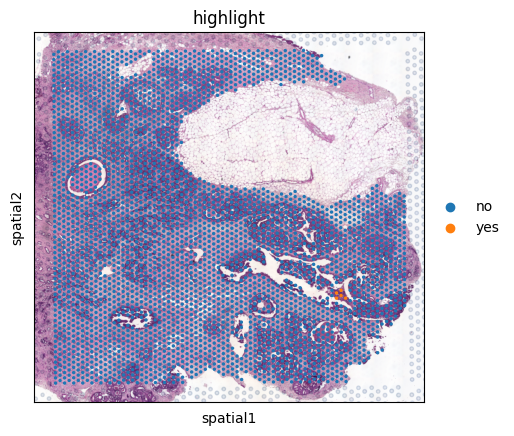

In [170]:
# spots with fewer neighbors make sense
plot_spot_neighbors(a, 'AAACAGAGCGACTCCT-1', key='spot_to_1hop_neighbors')

In [ ]:
# based on this will assume the following for hop neighborhoods


In [128]:
def tile_img(img, spot_radius, coords, nbrh_size=1):
    """
    tiles image for each spot
    
    img - H&E image, (H, W, C)
    spot_radius - radius of a spot in pixels for the given image resolution.
    coords - coordinates of spots - should be in same format as anndata.obsm['spatial'] (i.e. col, row)
    nbrh_size - int, number of spots surrounding spot in question
        i.e. if we have the following st section where each 
    """
    radius = spot_radius * zooms
    tiles = np.zeros((len(coords), radius * 2, radius * 2, img.shape[2]))
    for i, (c, r) in enumerate(coords):
        tiles[i] = img[r - radius:r + radius, c - radius:c + radius]
    return tiles

In [129]:
tile_blocks = {}
# tile 1x at 1 zoom
tile_blocks['1X_1zoom'] = tile_img(rescaled_dict['1X_trimmed'], res_dict['1X_trimmed']['spot_radius'],
                 a.obsm['spatial_trimmed'], zooms=1)

# tile 1x at 2 zoom
tiles = tile_img(rescaled_dict['1X_trimmed'], res_dict['1X_trimmed']['spot_radius'],
                 a.obsm['spatial_trimmed'], zooms=2)

In [130]:
tiles.shape

(3561, 162, 162, 3)

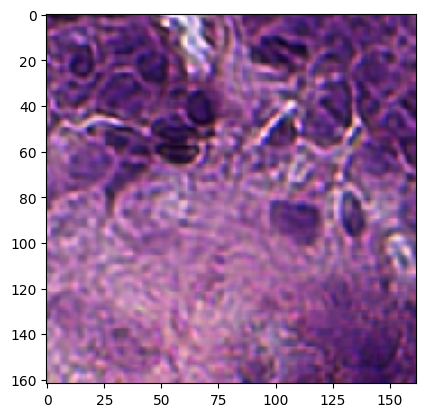

In [131]:
plt.imshow(tiles[10])

In [103]:
a.obs

in_tissue  array_row  array_col clusters alla_label
AAACAAGTATCTCCCA-1          1         50        102        0        NaN
AAACACCAATAACTGC-1          1         59         19        9      Tumor
AAACAGAGCGACTCCT-1          1         14         94        3        NaN
AAACAGCTTTCAGAAG-1          1         43          9       11        NaN
AAACAGGGTCTATATT-1          1         47         13        1        NaN
...                       ...        ...        ...      ...        ...
TTGTTCTAGATACGCT-1          1         21          3       11        NaN
TTGTTGGCAATGACTG-1          1         76         30        6        NaN
TTGTTTCACATCCAGG-1          1         58         42        2        NaN
TTGTTTCATTAGTCTA-1          1         60         30        6        NaN
TTGTTTGTATTACACG-1          1         73         41        5        NaN

[3561 rows x 5 columns]

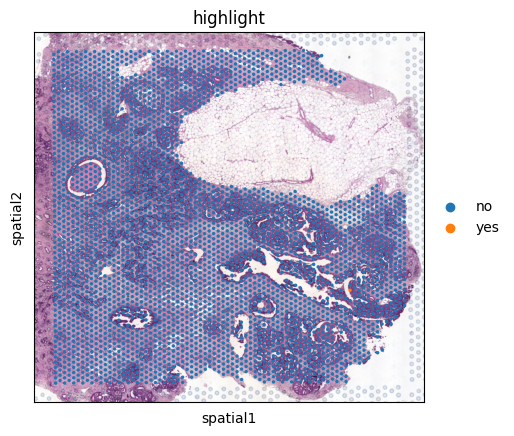

In [104]:
idx = 100
a.obs['highlight'] = ['yes' if s==a.obs.index[idx] else 'no'
                     for s in a.obs.index]
sc.pl.spatial(a, color='highlight')